This notebook is where I run tests or prepare the datasets.

In [1]:
import data_prep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from datetime import datetime

In [2]:
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
start = now.strftime("%d-%m-%Y %H:%M:%S")
print(start)

29-06-2022 18:50:39


In [3]:
df, frequency, forecast_horizon, missing_values, equal_len = data_prep.convert_tsf_to_dataframe('datasets/m3_monthly_dataset.tsf')
df.head()

,series_name,start_timestamp,series_value
0,T1,1990-01-01,"[2640.0, 2640.0, 2160.0, 4200.0, 3360.0, 2400...."
1,T2,1990-01-01,"[1680.0, 1920.0, 120.0, 1080.0, 840.0, 1440.0,..."
2,T3,1990-01-01,"[1140.0, 720.0, 4860.0, 1200.0, 3150.0, 2130.0..."
3,T4,1990-01-01,"[180.0, 940.0, 2040.0, 800.0, 1000.0, 520.0, 5..."
4,T5,1990-01-01,"[2000.0, 1550.0, 4450.0, 3050.0, 3050.0, 2250...."


In [4]:
print(len(df), frequency, forecast_horizon, missing_values, equal_len)

1428 monthly 18 False False


In [5]:
arr = df.values
arr = arr.T
d = {i: list(a) for i, a in enumerate(arr[2])}


In [7]:
lens = []
min_len = 130
for k, v in d.items():
    l = len(v)
    if l >= min_len:
        lens.append(l)

print(len(lens), np.mean(lens))

799 137.13266583229037


In [8]:
ls = d[1]

ls_x, ls_y = data_prep.ts_prep(ls, nlag=3, horizon=1)

from sklearn.neural_network import MLPRegressor

m = MLPRegressor(hidden_layer_sizes=(10, ))
m.fit(ls_x, ls_y)


/home/yukuan.lin/Desktop/DCTransformation/dclab01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yukuan.lin/Desktop/DCTransformation/dclab01/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(10,))

In [11]:
import xgboost as xgb

train_ls_x = ls_x[:-5]
train_ls_y = ls_y[:-5]

xgbreg = xgb.XGBRegressor(
    max_depth=5,
    booster='gbtree',
    subsample=0.5
)
xgbreg.fit(X=train_ls_x, y=train_ls_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [12]:
train_ls_y[:3]

array([[1080.],
       [ 840.],
       [1440.]])

In [13]:
train_ls_x[:3]

array([[1680., 1920.,  120.],
       [1920.,  120., 1080.],
       [ 120., 1080.,  840.]])

In [14]:
ls_x[-1]

array([1320., 1320., 2280.])

In [15]:
xgbreg.predict([ls_x[-1]])[0]

1701.307

In [16]:
import lightgbm as lgbm

lgbmreg = lgbm.LGBMRegressor(
    max_depth=5,
    min_split_gain=3,
    importance_type='split'
)

lgbmreg.fit(train_ls_x, train_ls_y.ravel())

LGBMRegressor(max_depth=5, min_split_gain=3)

In [18]:
lgbmreg.predict([ls_x[-1]])[0]

1292.0914116352997

: 

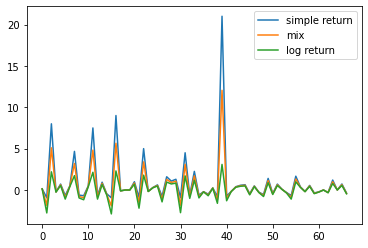

[1.1494989343464272, 3.1882663616451445, 2.0512705205256645]
[ 1.3213478  10.16504239  4.20771075]


In [73]:
def simple_return(ls):
    res = []
    for i, s in enumerate(ls):
        if i == 0: continue
        res.append((s - ls[i-1])/ls[i-1])
    return res

log_return = np.diff(np.log(ls))
simp_return = simple_return(ls)
mix = [np.mean([l, s]) for l, s in zip(log_return, simp_return)]


plt.plot(simp_return, label='simple return')
plt.plot(mix, label='mix')
plt.plot(log_return, label='log return')
plt.legend()
plt.show()
sigma = list(map(np.std, [log_return, simp_return, mix]))
print(sigma)
var = np.square(sigma)
print(var)

In [10]:
import json
import os
"""
# datetime object containing current date and time
now = datetime.now()

# dd/mm/YY H:M:S
start = now.strftime("%d-%m-%Y_%H:%M:%S")

isExist = os.path.exists(f'{start}/')

if not isExist:
    os.mkdir(f'{start}/')

d1 = {'1': 1, '2': 2}

with open(f'{start}/d1.json', 'x') as file:
    json.dump(d1, file, indent=4)
"""

In [41]:
import itertools

h = {
    '1': [1, 2, 3],
    '2': [(1, ), (1, 2), (1, 2, 3)]
}

tre = [0.1, 0.2, 0.3]

tres = list(itertools.product(tre, tre))

k = [(0.1, 0.2), (0.3, 0.4), (0.5, 0.6)]

nl = [7, 8, 9]

hs = [
    {
        'thres': hkk[0],
        'mhyper 1': hkk[1],
        'mhyper 2': hkk[2],
        'nllll': hkk[3]
    } for hkk in itertools.product(tres, *h.values(), nl)]
pprint(hs)

[{'mhyper 1': 1, 'mhyper 2': (1,), 'nllll': 7, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1,), 'nllll': 8, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1,), 'nllll': 9, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2), 'nllll': 7, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2), 'nllll': 8, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2), 'nllll': 9, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2, 3), 'nllll': 7, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2, 3), 'nllll': 8, 'thres': (0.1, 0.1)},
 {'mhyper 1': 1, 'mhyper 2': (1, 2, 3), 'nllll': 9, 'thres': (0.1, 0.1)},
 {'mhyper 1': 2, 'mhyper 2': (1,), 'nllll': 7, 'thres': (0.1, 0.1)},
 {'mhyper 1': 2, 'mhyper 2': (1,), 'nllll': 8, 'thres': (0.1, 0.1)},
 {'mhyper 1': 2, 'mhyper 2': (1,), 'nllll': 9, 'thres': (0.1, 0.1)},
 {'mhyper 1': 2, 'mhyper 2': (1, 2), 'nllll': 7, 'thres': (0.1, 0.1)},
 {'mhyper 1': 2, 'mhyper 2': (1, 2), 'nllll': 8, 'thres': (0.1, 0.1)},
 {'mhyper

In [44]:
nl = [{j: i for j in range(3)} for i in range(5)]

b = nl[1]
t = nl[0]

del b[1]
print(b, t)

{0: 1, 2: 1} {0: 0, 1: 0, 2: 0}


In [7]:
print(hs[0])
print(hs[0][0][0], hs[0][0][1])
print(hs[0][1:])

((0.1, 0.1), 1, (1,))
0.1 0.1
(1, (1,))


# validation, test demo

In [4]:
ts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

n_val = 3
n_test = 3
n_lag = 3
h = 1

split = n_val + n_test

for i in range(n_val):
    train_v = ts[:-split+1+i]
    train = train_v[:-h]
    val = train_v[-h:]
    ttrain = [t*0.9 for t in train] # transformation
    # ttrain = train
    tX, ty = data_prep.ts_prep(ttrain, nlag=n_lag, horizon=h)
    ttrainx, tvalx = tX, ttrain[-n_lag:]
    ttrainy, valy = ty, val

    pprint(ttrainx)
    pprint(ttrainy)
    pprint(tvalx)
    pprint(valy)
    print(train)


array([[0.9, 1.8, 2.7],
       [1.8, 2.7, 3.6],
       [2.7, 3.6, 4.5],
       [3.6, 4.5, 5.4]])
array([[3.6],
       [4.5],
       [5.4],
       [6.3]])
[4.5, 5.4, 6.3]
[8]
[1, 2, 3, 4, 5, 6, 7]
array([[0.9, 1.8, 2.7],
       [1.8, 2.7, 3.6],
       [2.7, 3.6, 4.5],
       [3.6, 4.5, 5.4],
       [4.5, 5.4, 6.3]])
array([[3.6],
       [4.5],
       [5.4],
       [6.3],
       [7.2]])
[5.4, 6.3, 7.2]
[9]
[1, 2, 3, 4, 5, 6, 7, 8]
array([[0.9, 1.8, 2.7],
       [1.8, 2.7, 3.6],
       [2.7, 3.6, 4.5],
       [3.6, 4.5, 5.4],
       [4.5, 5.4, 6.3],
       [5.4, 6.3, 7.2]])
array([[3.6],
       [4.5],
       [5.4],
       [6.3],
       [7.2],
       [8.1]])
[6.3, 7.2, 8.1]
[10]
[1, 2, 3, 4, 5, 6, 7, 8, 9]


In [13]:
for i in range(n_test):
    if i == n_test-1:
        train = ts
    else:
        train = ts[:-n_test+1+i]

    # ttrain = [t*0.9 for t in train] # transformation
    tX, ty = data_prep.ts_prep(train, nlag=n_lag, horizon=h)
    ttrainx, ttestx = tX[:-1], tX[-1]
    ttrainy, testy = ty[:-1], train[-h]

    pprint(ttrainx)
    pprint(ttrainy)
    pprint(ttestx)
    pprint(testy)
    print(train)

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])
array([[ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])
array([ 8,  9, 10])
11
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
array([[ 1,  2,  3],
       [ 2,  3,  4],
       [ 3,  4,  5],
       [ 4,  5,  6],
       [ 5,  6,  7],
       [ 6,  7,  8],
       [ 7,  8,  9],
       [ 8,  9, 10]])
array([[ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11]])
array([ 9, 10, 11])
12
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
array([[ 1,  2,  3],
       [ 2,  3,  4],
       [ 3,  4,  5],
       [ 4,  5,  6],
       [ 5,  6,  7],
       [ 6,  7,  8],
       [ 7,  8,  9],
       [ 8,  9, 10],
       [ 9, 10, 11]])
array([[ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12]])
array([10, 11, 12])
13
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [75]:
measure = {'SAPE': lambda y, y_hat: np.abs(y_hat-y)/np.mean((np.abs(y_hat), np.abs(y)))}

k = np.array([10])[0]
measure['SAPE'](9, k)

0.10526315789473684